# Convolutional Neural Network

# 1)-Import key modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.utils import np_utils
from wandb.keras import WandbCallback
from keras.callbacks import TensorBoard
import wandb
import os
import tensorflow as tf

Using TensorFlow backend.


In [3]:
run = wandb.init()
config = run.config
config.first_layer_convs = 32
config.first_layer_conv_width = 3
config.first_layer_conv_height = 3
config.dropout = 0.2
config.dense_layer_size = 128
config.img_width = 28
config.img_height = 28
config.epochs = 4
batch_size = 256

wandb: ERROR To use wandb on Windows, you need to run the command "wandb run python <your_train_script>.py"


# 2)-Loading data

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 3) Checking data

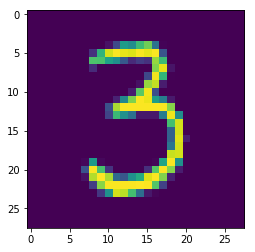

In [5]:
image = X_train[50, :].reshape((28, 28)) # checking a random row i.e 50 for image

plt.imshow(image)
plt.show()

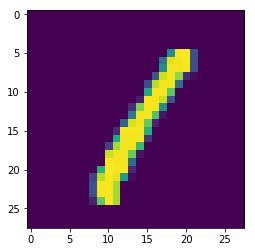

In [6]:
image = X_train[3, :].reshape((28, 28)) 

plt.imshow(image)
plt.show()

In [7]:
print(X_train.shape[0])
print(X_train.shape[1])
print(X_train.shape[2])

60000
28
28


In [8]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]

In [9]:
print(img_width)

28


### a.Normalize

In [10]:
X_train = X_train.astype('float32')
X_train /= 255.
X_test = X_test.astype('float32')
X_test /= 255.

### b.reshape

In [11]:
# reshape input data
X_train = X_train.reshape(
    X_train.shape[0], config.img_width, config.img_height, 1)
X_test = X_test.reshape(
    X_test.shape[0], config.img_width, config.img_height, 1)

### c.one hot encode

In [12]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
labels = range(10)

# 4)- build model

In [13]:
model = Sequential()
model.add(Conv2D(32,
                 (config.first_layer_conv_width, config.first_layer_conv_height),
                 input_shape=(28, 28, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(config.dense_layer_size, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'], weighted_metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model
history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10, verbose=1,
        validation_data=(X_test, y_test)
    )

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 295us/step - loss: 0.2868 - acc: 0.9203 - weighted_acc: 0.9203 - val_loss: 0.1112 - val_acc: 0.9679 - val_weighted_acc: 0.9679
Epoch 2/10
60000/60000 [==============================] - 17s 287us/step - loss: 0.0828 - acc: 0.9757 - weighted_acc: 0.9757 - val_loss: 0.0637 - val_acc: 0.9795 - val_weighted_acc: 0.9795
Epoch 3/10
60000/60000 [==============================] - 17s 285us/step - loss: 0.0566 - acc: 0.9833 - weighted_acc: 0.9833 - val_loss: 0.0508 - val_acc: 0.9826 - val_weighted_acc: 0.9826
Epoch 4/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.0435 - acc: 0.9872 - weighted_acc: 0.9872 - val_loss: 0.0501 - val_acc: 0.9830 - val_weighted_acc: 0.9830
Epoch 5/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.0348 - acc: 0.9895 - weighted_acc: 0.9895 - val_loss: 0.0474 - 

# 5)- Evaluating 

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04482745918013388
Test accuracy: 0.9856


In [17]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

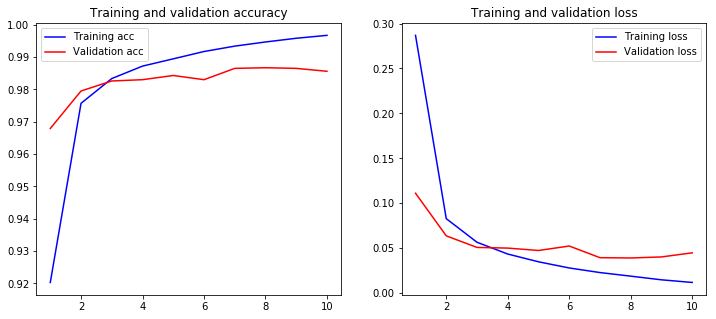

In [18]:
plot_history(history)

Note how training accuracy has reached almost 100%. this is a potential issue of overfitting.

We may get better results by using **dropout**

# 6)- Debugging

### Adding Dropout

In [19]:
model = Sequential()
model.add(Conv2D(32,
                 (config.first_layer_conv_width, config.first_layer_conv_height),
                 input_shape=(28, 28, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(config.dense_layer_size, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'], weighted_metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               692352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para

In [21]:
# Fit the model
history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10, verbose=1,
        validation_data=(X_test, y_test)
    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s 379us/step - loss: 0.3680 - acc: 0.8925 - weighted_acc: 0.8925 - val_loss: 0.1097 - val_acc: 0.9673 - val_weighted_acc: 0.9673
Epoch 2/10
60000/60000 [==============================] - 23s 376us/step - loss: 0.1316 - acc: 0.9614 - weighted_acc: 0.9614 - val_loss: 0.0683 - val_acc: 0.9779 - val_weighted_acc: 0.9779
Epoch 3/10
60000/60000 [==============================] - 23s 381us/step - loss: 0.0999 - acc: 0.9703 - weighted_acc: 0.9703 - val_loss: 0.0564 - val_acc: 0.9805 - val_weighted_acc: 0.9805
Epoch 4/10
60000/60000 [==============================] - 21s 347us/step - loss: 0.0846 - acc: 0.9739 - weighted_acc: 0.9739 - val_loss: 0.0487 - val_acc: 0.9836 - val_weighted_acc: 0.9836
Epoch 5/10
60000/60000 [==============================] - 21s 347us/step - loss: 0.0698 - acc: 0.9786 - weighted_acc: 0.9786 - val_loss: 0.0477 - val_acc: 0.9838 - val_weighted_acc: 0.9838
Epoch

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04002520736116567
Test accuracy: 0.9858


In [23]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

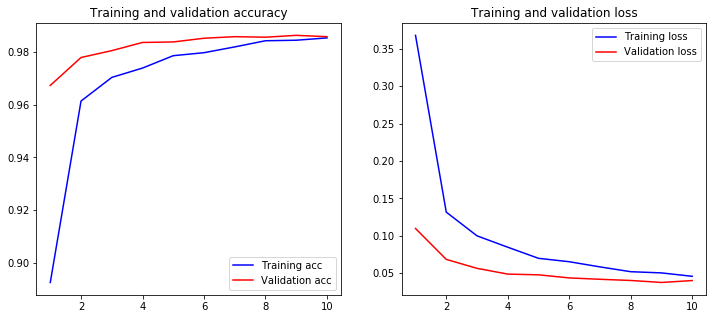

In [24]:
plot_history(history)

# 7)-Applying three layered CNN

In [27]:
#Trying again with same dataset
(x_train, y_train), (x_test , y_test) = mnist.load_data()

In [28]:
# reshape the data
im_rows = 28
im_cols = 28
batch_size = 256
im_shape = (im_rows, im_cols, 1)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *im_shape)

print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_validate shape: (10000, 28, 28, 1)


### a. Building three layers of model

In [29]:
# CNN model consisting of three layers

name = '1_Layer'
cnn_model_1 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=im_shape, name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.2, name='Dropout'),
    Flatten(name='flatten'),
    Dense(32, activation='relu', name='Dense'),
    Dense(10, activation='softmax', name='Output')
], name=name)

name = '2_Layer'
cnn_model_2 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=im_shape, name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.2, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Flatten(name='flatten'),
    Dense(64, activation='relu', name='Dense'),
    Dense(10, activation='softmax', name='Output')
], name=name)

name='3_layer'
cnn_model_3 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', 
           input_shape=im_shape, kernel_initializer='he_normal', name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.25, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Conv2D(128, kernel_size=3, activation='relu', name='Conv2D-3'),
    Dropout(0.4, name='Dropout-3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='Dense'),
    Dropout(0.4, name='Dropout'),
    Dense(10, activation='softmax', name='Output')
], name=name)

cnn_models = [cnn_model_1, cnn_model_2, cnn_model_3]

In [30]:
for model in cnn_models:
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 13, 13, 32)        0         
_________________________________________________________________
Dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
Dense (Dense)                (None, 32)                173088    
_________________________________________________________________
Output (Dense)               (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_________________________________________________________________
____

### b.Fitting model

In [31]:
# train the models and save results to a dict

history_dict = {}

for model in cnn_models:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=10, verbose=1,
        validation_data=(x_validate, y_validate)
    )
    
    history_dict[model.name] = history

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 18s 295us/step - loss: 2.1156 - acc: 0.8175 - val_loss: 0.1698 - val_acc: 0.9602
Epoch 2/10
60000/60000 [==============================] - 18s 295us/step - loss: 0.1571 - acc: 0.9578 - val_loss: 0.1144 - val_acc: 0.9714
Epoch 3/10
60000/60000 [==============================] - 17s 290us/step - loss: 0.1007 - acc: 0.9717 - val_loss: 0.0960 - val_acc: 0.9754
Epoch 4/10
60000/60000 [==============================] - 17s 287us/step - loss: 0.0743 - acc: 0.9784 - val_loss: 0.0813 - val_acc: 0.9778
Epoch 5/10
60000/60000 [==============================] - 19s 324us/step - loss: 0.0572 - acc: 0.9832 - val_loss: 0.0827 - val_acc: 0.9772
Epoch 6/10
60000/60000 [==============================] - 19s 319us/step - loss: 0.0491 - acc: 0.9850 - val_loss: 0.0923 - val_acc: 0.9778
Epoch 7/10
60000/60000 [==============================] - 19s 323us/step - loss: 0.0406 - acc: 0.9870 - val_loss: 0.

### c. ploting results of loss and accuracy

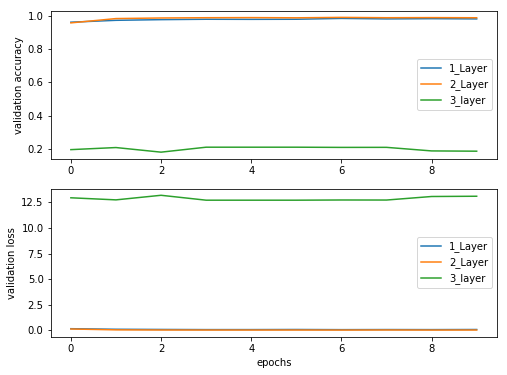

In [32]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for history in history_dict:
    val_acc = history_dict[history].history['val_acc']
    val_loss = history_dict[history].history['val_loss']
    ax1.plot(val_acc, label=history)
    ax2.plot(val_loss, label=history)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

We can see that 3rd layer gives very low accuracy results while other 2 layers have very high accuracy results